# Visión por Computadora II - 2025 - B4 - Trabajo práctico integrador
**Inteligencia Artificial - CEIA - FIUBA**

## Autores

- **Mendoza Dante**.

- **Vasquez Jorge**.

- **Viñas Gustavo**.

**Dataset elegido:** https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset

**Descripcion:** Detección de enfermedades en cultivos agrícolas. Entrenar un modelo que identifique y clasifique enfermedades en plantas a partir de imágenes, ayudando a los agricultores a tomar medidas preventivas y reducir pérdidas.​

**Enfoque:** Entrenar un modelo para identificar una enfermedad específica en una especie de planta utilizando imágenes.​

# 💻 Montaje de entorno y definición de rutas

- Definir entorno de proyecto.

- Visualizar las rutas del dataset.

In [1]:
%pip install --quiet pandas matplotlib scikit-learn torch torchvision 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import os
from zipfile import ZipFile

# Funcion auxiliar para descargar el dataset
def download_dataset(target_dir, subset: str | None = None, force: bool = False):
    dataset_url = "https://www.kaggle.com/api/v1/datasets/download/abdallahalidev/plantvillage-dataset"
    dataset_folder = "plantvillage dataset"
    tmp_file = "tmp.zip"

    if not(subset is None or subset.lower() in ["color", "grayscale", "segmented"]):
        raise Exception("subset debe ser None, color, grayscale o segmented")
    
    if os.path.isdir(target_dir) and not force:
        if subset is None:
            print("Dataset folder already exists, nothing downloaded.")
            return
        if os.path.isdir(os.path.join(target_dir, subset)):
            print(f"Folder already exists for subset \"{subset}\", nothing downloaded.")
            return

    try:
        with requests.get(dataset_url, stream=True) as response:
            response.raise_for_status()  # Raise an exception for bad status codes

            with open(tmp_file, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"File '{tmp_file}' downloaded successfully.")
    except requests.exceptions.RequestException as e:
        if (os.path.isfile(tmp_file)):
            os.remove(tmp_file)
        raise(Exception(f"Error downloading file: {e}"))

    try:
        with ZipFile(tmp_file, 'r') as zip_object:
            for member in zip_object.infolist():
                if member.filename.startswith(dataset_folder):
                    member.filename = member.filename[len(dataset_folder)+1:]
                    if subset is None or member.filename.startswith(subset):
                        zip_object.extract(member, target_dir)
        print(f"Successfully extracted '{tmp_file}' to '{target_dir}' for " + ('all subsets' if subset is None else f"{subset} subset") + ".")

    except FileNotFoundError:
        raise(Exception(f"Error: The file '{tmp_file}' was not found."))
    except Exception as e:
        raise(Exception(f"An error occurred: {e}"))
    finally:
        if (os.path.isfile(tmp_file)):
            os.remove(tmp_file)


In [3]:
# ====================================================
# MONTAJE DE ENTORNO Y DEFINICIÓN DE RUTAS
# ====================================================

# Descargamos el dataset si no existe la carpeta
base_dir = "datasets"
subset = "color"
download_dataset(base_dir, subset)


# Ruta al dataset
DATASET_PATH = os.path.join(base_dir, subset)

print("Ruta del dataset:", DATASET_PATH)
print("Listado de carpetas:", os.listdir(DATASET_PATH)[:10])

File 'tmp.zip' downloaded successfully.
Successfully extracted 'tmp.zip' to 'datasets' for color subset.
Ruta del dataset: datasets\color
Listado de carpetas: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy']


# 💻 EDA del PlantVillage (color).

- Listar las clases (carpetas).

- Contar cuántas imágenes hay por clase.

- Graficar la distribución de imágenes.

- Mostrar ejemplos de imágenes de distintas clases.

Número de clases encontradas: 38
Listado de clases: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy']

Distribución de imágenes por clase (Top 10):
                                               num_images
Orange___Haunglongbing_(Citrus_greening)             5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus               5357
Soybean___healthy                                    5090
Peach___Bacterial_spot                               2297
Tomato___Bacterial_spot                              2127
Tomato___Late_blight                                 1909
Squash___Powdery_mildew                              1835
Tomato___Septoria_leaf_spot                          1771
Tomato___Spider_mites Two-spotted_spider_mite        1676
Apple___healthy 

<Figure size 1000x600 with 0 Axes>

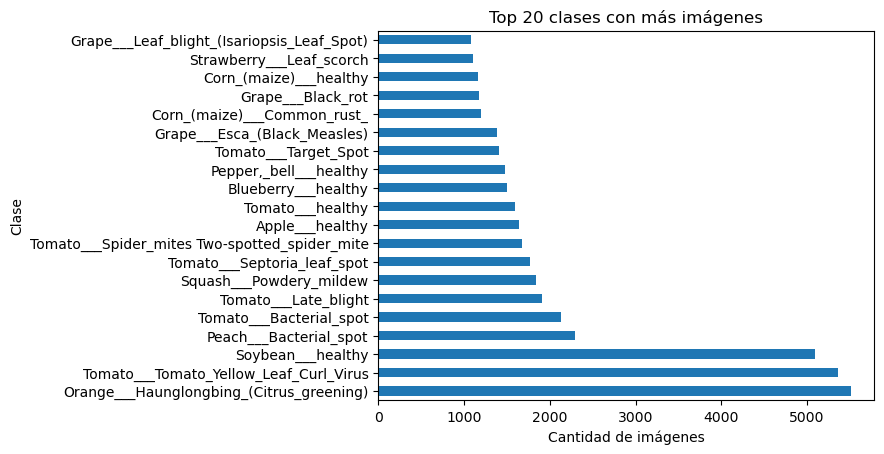

In [4]:
# ====================================================
# ANÁLISIS EXPLORATORIO (EDA)
# ====================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import random


# Listamos las clases disponibles
classes = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
print("Número de clases encontradas:", len(classes))
print("Listado de clases:", classes[:10])

# Contamos las imágenes por clase
counts = {}
for c in classes:
    folder = os.path.join(DATASET_PATH, c)
    counts[c] = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['num_images']).sort_values('num_images', ascending=False)
print("\nDistribución de imágenes por clase (Top 10):")
print(df_counts.head(10))

# Graficamos la distribución de imágenes por clase (Top 20)
plt.figure(figsize=(10,6))
df_counts.head(20).plot(kind='barh', legend=False)
plt.title("Top 20 clases con más imágenes")
plt.xlabel("Cantidad de imágenes")
plt.ylabel("Clase")
plt.show()

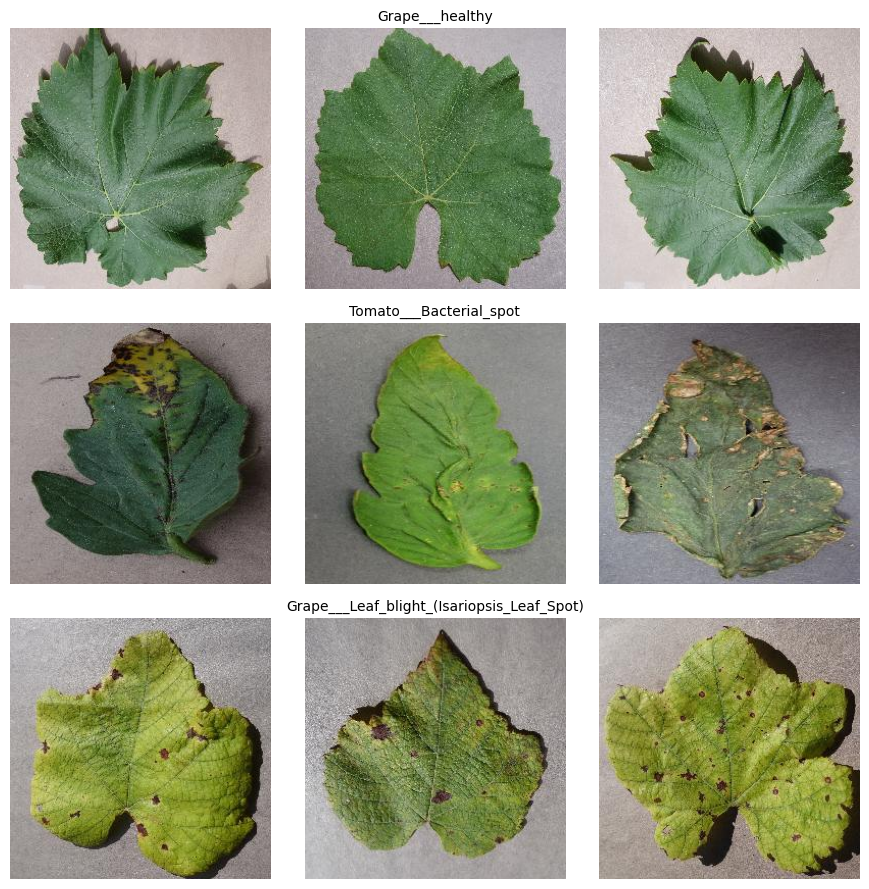

In [5]:
SAMPLE_CLASS_NUM = 3  # número de clases a mostrar al azar
SAMPLE_IMAGE_NUM = 3  # número de imágenes por clase a mostrar al azar

# Mostramos algunos ejemplos aleatorios de imágenes de distintas clases
sample_classes = random.sample(classes, min(SAMPLE_CLASS_NUM, len(classes)))
fig, axes = plt.subplots(len(sample_classes), SAMPLE_IMAGE_NUM, figsize=(9, 9))

for i, cls in enumerate(sample_classes):
    folder = os.path.join(DATASET_PATH, cls)
    imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    sample_imgs = random.sample(imgs, min(SAMPLE_IMAGE_NUM, len(imgs)))

    for j, imn in enumerate(sample_imgs):
        img = Image.open(os.path.join(folder, imn)).convert('RGB')
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 1:
            axes[i, j].set_title(cls, fontsize=10)

plt.tight_layout()
plt.show()


Extensiones encontradas: Counter({'.jpg': 54303, '.png': 1, '.jpeg': 1})

Estadísticas de resoluciones (muestra):
         width   height
count  17910.0  17910.0
mean     256.0    256.0
std        0.0      0.0
min      256.0    256.0
25%      256.0    256.0
50%      256.0    256.0
75%      256.0    256.0
max      256.0    256.0


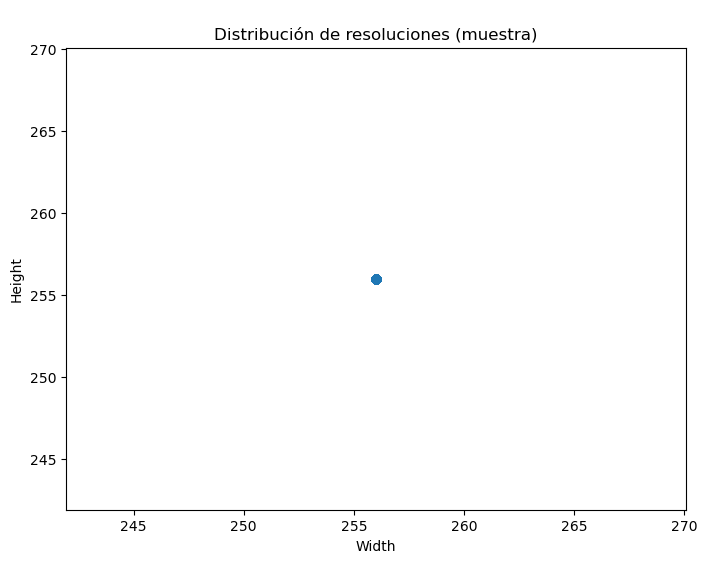


Distribución de número de canales en imágenes (muestra): Counter({3: 17910})


In [6]:
# ====================================================
# Exploramos formato, resoluciones y canales.
# ====================================================

# Revisamos las extensiones de archivos
extensiones = []
for cls in classes:
    folder = os.path.join(DATASET_PATH, cls)
    imgs = [f for f in os.listdir(folder)]
    extensiones.extend([os.path.splitext(f)[1].lower() for f in imgs])

ext_counter = Counter(extensiones)
print("\nExtensiones encontradas:", ext_counter)

# Revisamos las resoluciones y canales (se toma una muestra para no tardar mucho)
SAMPLE_CLASS_NUM = 50 # número de clases a analizar al azar
SAMPLE_IMAGE_NUM = 500 # número máximo de imágenes por clase a analizar al azar

resolutions = []
channels = []

for cls in random.sample(classes, min(SAMPLE_CLASS_NUM, len(classes))):
    folder = os.path.join(DATASET_PATH, cls)
    imgs = random.sample(os.listdir(folder), min(SAMPLE_IMAGE_NUM, len(os.listdir(folder))))
    for imn in imgs:
        if imn.lower().endswith(('.jpg', '.png', '.jpeg')):
            try:
                img = Image.open(os.path.join(folder, imn))
                resolutions.append(img.size)
                channels.append(len(img.getbands()))
            except:
                pass

# Distribución de resoluciones
res_df = pd.DataFrame(resolutions, columns=["width", "height"])
print("\nEstadísticas de resoluciones (muestra):")
print(res_df.describe())

# Graficar distribución de resoluciones
plt.figure(figsize=(8,6))
plt.scatter(res_df["width"], res_df["height"], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("\nDistribución de resoluciones (muestra)")
plt.show()

# Chequeo de canales
chan_counter = Counter(channels)
print("\nDistribución de número de canales en imágenes (muestra):", chan_counter)


🔎 Exploración inicial del dataset

- Identificamos 38 clases correspondientes a combinaciones de planta + enfermedad/saludable.
- El dataset está desbalanceado, algunas clases tienen más de 5000 imágenes como el Orange Haunglongbing (Citrus_greening).  
  Otras cuentan con menos de 200 imágenes como Tomato Early Blight.
- Todas las imágenes tienen tamaño fijo de 256×256 píxeles.
- Casi todas las imágenes están en formato .jpg, tambien existen algunas en png o jpeg pero son una minoria.
- Todas las imágenes son RGB (3 canales), excepto una que tiene 4 canales.
- Debido al desbalanceo de clases, será importante aplicar Data Augmentation.

# 💻 Preparamos el dataset (split + DataLoader)

- Vamos a tomar todas las clases.

- Creamos carpetas train/val/test con split 70/15/15.

- Definimos DataLoader en PyTorch con transformaciones (resize, normalización, data augmentation).

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
import numpy as np

class TransformationDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [8]:
batch_size = 32

full_dataset = datasets.ImageFolder(DATASET_PATH)

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [0.7, 0.15, 0.15])

transform_train = transforms.Compose([
    # Creo variantes de las imagenes para evitar overfitting al hacer oversampling
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Escala entre 0 y 1; pasa a tensor; poner canales en 1ra dim
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),# Escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataloader = DataLoader(TransformationDataset(train_dataset, transform_train), batch_size=batch_size, pin_memory=True)
val_dataloader = DataLoader(TransformationDataset(val_dataset, transform_val_test), batch_size=batch_size, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(TransformationDataset(test_dataset, transform_val_test), batch_size=batch_size, shuffle=False, pin_memory=True)


In [9]:
print("Distribucion de muestras:")
print("\nFull: ", len(full_dataset), "\nTrain:", len(train_dataset), "\nVal:", len(val_dataset), "\nTest:", len(test_dataset))
print(f"\nNúmero de clases totales. Train: {len(train_dataset.dataset.classes)}. Val: {len(val_dataset.dataset.classes)}. Test: {len(test_dataset.dataset.classes)}")

Distribucion de muestras:

Full:  54305 
Train: 38014 
Val: 8146 
Test: 8145

Número de clases totales. Train: 38. Val: 38. Test: 38


In [10]:
print("Clases -> ids:")
idx_to_class = {v: i for i,v in train_dataset.dataset.class_to_idx.items()}
print(train_dataset.dataset.class_to_idx)
print("Ids -> clases:")
print(idx_to_class)

Clases -> ids:
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_bligh

In [11]:
# Cargamos un batch del dataloader para probar que todo este ok
train_features, train_labels = next(iter(train_dataloader))

In [12]:
# verificamos sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

Tamaño del batch de feature (input / imagen): torch.Size([32, 3, 256, 256])
Tamaño del batch del label (clase / etiqueta): torch.Size([32])


tamaño de 1 imagen:  torch.Size([1, 3, 256, 256])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([256, 256, 3])


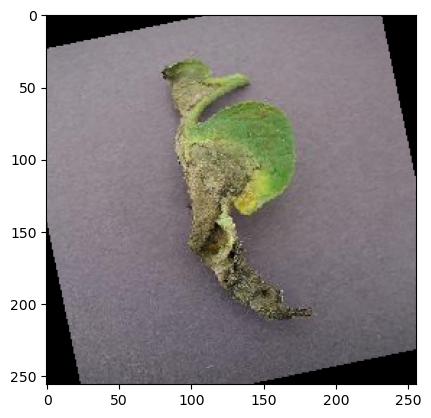

Label: 30 (Tomato___Late_blight)


In [13]:
# tomamos 1 imagen para poder visualizarla y verificar sus dimensiones

img_idx = torch.randint(len(train_features), (1,))
img = train_features[img_idx]
print('tamaño de 1 imagen: ', img.shape)
# le quitamos 1 dimension (la del tamaño del batch) y reordenamos para poder graficar
img = img.squeeze().permute(1, 2, 0)
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[img_idx]

# Unnormalize
img = np.array([0.229, 0.224, 0.225]) * img.numpy() + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1) # Clip values to be between 0 and 1

# ploteo esa imagen
plt.imshow(img)
plt.show()
print(f"Label: {label.item()} ({idx_to_class[label.item()]})")